# **Consumer Analytical Profile Analysis (LDP) for 1 Day Interactions**

In [ ]:
%run feature_engineering/bi_feature_eng_utilities.ipynb
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

2019-08-02 20:27:32.042 ERROR execution.py.657 - File `'feature_engineering/bi_feature_eng_utilities.ipynb.py'` not found.
sagemaker 1.33.0 has requirement urllib3<1.25,>=1.21, but you'll have urllib3 1.25.3 which is incompatible.
requests 2.20.0 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.3 which is incompatible.
awscli 1.16.198 has requirement botocore==1.12.188, but you'll have botocore 1.12.199 which is incompatible.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
sagemaker 1.33.0 has requirement urllib3<1.25,>=1.21, but you'll have urllib3 1.25.3 which is incompatible.
requests 2.20.0 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.3 which is incompatible.
awscli 1.16.198 has requirement botocore==1.12.188, but you'll have botocore 1.12.199 which is incompatible.
You are using pip version 10.0.1, however version 19.2.1 is available.
You shou

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing

# Random Sample input data if too large this number should be presented as integer ]0,100]
sample_rate_percentage = 100

s3 = s3fs.S3FileSystem()

In [3]:
# It runs k-mean for up to up_to_max_cluster_number ()
def run_k_mean(df, up_to_max_cluster_number, title):
    distortions = []
    for i in range(1, up_to_max_cluster_number):
        print('iteration {}'.format(i))
        km = KMeans(
            n_clusters=i, 
            init='random',
            n_init=10, 
            max_iter=300,
            tol=1e-04, 
            random_state=0,
            n_jobs=multiprocessing.cpu_count()-2 
        )
        km.fit(df)
        distortions.append(km.inertia_)

    df_labels = km.predict(df)
    df_centroids = km.cluster_centers_

    # plot number of clusters against distoration to find optimal number of clusters for 
    plt.plot(range(1, up_to_max_cluster_number), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.show()

    return (df_labels, df_centroids, distortions )

In [4]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-08-02 18:42:57.125 INFO athena_util.py.111 - Read config from default schema
2019-08-02 18:42:57.126 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t001',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

2019-08-02 18:42:59.715 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:42:59.830 INFO athena_util.py.462 - 2019-08-02 18:42:59.830372
2019-08-02 18:43:01.940 INFO athena_util.py.464 - 2019-08-02 18:43:01.940492
2019-08-02 18:43:02.068 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:43:02.193 INFO athena_util.py.462 - 2019-08-02 18:43:02.193619
2019-08-02 18:43:12.165 INFO athena_util.py.464 - 2019-08-02 18:43:12.165835


0

In [6]:
res = user_interactions_db_handler.get_table_size('biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(
    str(int((100/sample_rate_percentage)*100))))
print(res)

2019-08-02 18:43:12.237 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-02 18:43:12.299 INFO athena_util.py.462 - 2019-08-02 18:43:12.299332
2019-08-02 18:43:13.855 INFO athena_util.py.464 - 2019-08-02 18:43:13.855523
6730856


In [7]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(str(int((100/sample_rate_percentage)*100))))
print(s3_data_path)

s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_sampled_100_consumer_analytical_profile_summary_t001


In [8]:
df = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()

## **Basic Statistical Analysis : Dimension Reduction**

In [10]:
#Clean up non-numeric variables for k-mean
df = df.drop(columns=['snapshot_date_mst_yyyymmdd','member_id','most_recent_ldp_visit_date', 'ldp_dominant_zip'])

In [11]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['for sale' 'no_segment' 'for rent' 'not for sale']


In [12]:
unique_number_of_segments = len(unique_segments)
print(unique_number_of_segments)

4


In [13]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['for sale' 'no_segment' 'for rent' 'not for sale']


### Now Partition Based on different Segments like : ['for sale' 'not for sale' 'no_segment' 'for rent']

In [14]:
df_for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
df_no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
df_not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale']
df_for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent']

In [16]:
#Get correlation matrix for possible dimension reduction
corr_df_for_sale = df_for_sale.corr()
corr_df_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.106203,0.26674,0.00140645,0.696404,-0.0585505,-0.0658463,0.371076,0.895266,0.895771,0.895266,0.895266,0.895771,0.895771
median_ldp_page_views,0.106203,1,0.789969,0.346014,0.125335,0.370399,0.248449,0.182805,-0.0106466,-0.0105511,-0.0106466,-0.0106466,-0.0105511,-0.0105511
average_ldp_page_views,0.26674,0.789969,1,0.343831,0.266937,0.268645,0.214814,0.31471,0.0851662,0.0854566,0.0851662,0.0851662,0.0854566,0.0854566
average_ldp_dwell_time_seconds,0.00140645,0.346014,0.343831,1,0.288092,0.875441,0.79968,0.564346,-0.0494603,-0.0493788,-0.0494603,-0.0494603,-0.0493788,-0.0493788
total_ldp_dwell_time_seconds,0.696404,0.125335,0.266937,0.288092,1,0.105955,0.0250058,0.772662,0.601804,0.602851,0.601804,0.601804,0.602851,0.602851
median_ldp_dwell_time_seconds,-0.0585505,0.370399,0.268645,0.875441,0.105955,1,0.735492,0.311592,-0.093059,-0.0931316,-0.093059,-0.093059,-0.0931316,-0.0931316
minimum_ldp_dwell_time_seconds,-0.0658463,0.248449,0.214814,0.79968,0.0250058,0.735492,1,0.184472,-0.0893164,-0.089421,-0.0893164,-0.0893164,-0.089421,-0.089421
maximum_ldp_dwell_time_seconds,0.371076,0.182805,0.31471,0.564346,0.772662,0.311592,0.184472,1,0.296801,0.297392,0.296801,0.296801,0.297392,0.297392
total_distinct_listings_viewed,0.895266,-0.0106466,0.0851662,-0.0494603,0.601804,-0.093059,-0.0893164,0.296801,1,0.999815,1,1,0.999815,0.999815
total_listings_viewed,0.895771,-0.0105511,0.0854566,-0.0493788,0.602851,-0.0931316,-0.089421,0.297392,0.999815,1,0.999815,0.999815,1,1


In [18]:
corr_df_no_segment = df_no_segment.corr()
corr_df_no_segment.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0873531,0.135605,0.00814761,0.666698,-0.0353946,-0.0410972,0.326546,0.89015,0.89057,0.89015,0.89015,0.89057,0.89057
median_ldp_page_views,0.0873531,1,0.979183,0.319729,0.0667447,0.304664,0.328584,0.16361,-0.066484,-0.0667349,-0.066484,-0.066484,-0.0667349,-0.0667349
average_ldp_page_views,0.135605,0.979183,1,0.318838,0.10816,0.278603,0.328891,0.194519,-0.0332032,-0.033442,-0.0332032,-0.0332032,-0.033442,-0.033442
average_ldp_dwell_time_seconds,0.00814761,0.319729,0.318838,1,0.389674,0.93893,0.905959,0.692842,-0.0552694,-0.0549857,-0.0552694,-0.0552694,-0.0549857,-0.0549857
total_ldp_dwell_time_seconds,0.666698,0.0667447,0.10816,0.389674,1,0.294602,0.200472,0.798071,0.611515,0.611761,0.611515,0.611515,0.611761,0.611761
median_ldp_dwell_time_seconds,-0.0353946,0.304664,0.278603,0.93893,0.294602,1,0.802709,0.590308,-0.0901002,-0.0899373,-0.0901002,-0.0901002,-0.0899373,-0.0899373
minimum_ldp_dwell_time_seconds,-0.0410972,0.328584,0.328891,0.905959,0.200472,0.802709,1,0.4467,-0.0961871,-0.0955884,-0.0961871,-0.0961871,-0.0955884,-0.0955884
maximum_ldp_dwell_time_seconds,0.326546,0.16361,0.194519,0.692842,0.798071,0.590308,0.4467,1,0.266252,0.265929,0.266252,0.266252,0.265929,0.265929
total_distinct_listings_viewed,0.89015,-0.066484,-0.0332032,-0.0552694,0.611515,-0.0901002,-0.0961871,0.266252,1,0.999647,1,1,0.999647,0.999647
total_listings_viewed,0.89057,-0.0667349,-0.033442,-0.0549857,0.611761,-0.0899373,-0.0955884,0.265929,0.999647,1,0.999647,0.999647,1,1


In [20]:
corr_df_not_for_sale = df_not_for_sale.corr()
corr_df_not_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.231473,0.346314,0.0250514,0.518518,0.00241271,-0.0428977,0.256592,0.83657,0.836639,0.83657,0.83657,0.836639,0.836639
median_ldp_page_views,0.231473,1,0.895755,0.210067,0.156601,0.249128,0.152498,0.201706,-0.0244351,-0.0243505,-0.0244351,-0.0244351,-0.0243505,-0.0243505
average_ldp_page_views,0.346314,0.895755,1,0.253624,0.225719,0.262715,0.195663,0.264217,0.00799217,0.00806493,0.00799217,0.00799217,0.00806493,0.00806493
average_ldp_dwell_time_seconds,0.0250514,0.210067,0.253624,1,0.618494,0.965873,0.95188,0.828219,-0.043961,-0.0439718,-0.043961,-0.043961,-0.0439718,-0.0439718
total_ldp_dwell_time_seconds,0.518518,0.156601,0.225719,0.618494,1,0.557351,0.457506,0.880675,0.457752,0.458093,0.457752,0.457752,0.458093,0.458093
median_ldp_dwell_time_seconds,0.00241271,0.249128,0.262715,0.965873,0.557351,1,0.903429,0.764628,-0.0669225,-0.0669304,-0.0669225,-0.0669225,-0.0669304,-0.0669304
minimum_ldp_dwell_time_seconds,-0.0428977,0.152498,0.195663,0.95188,0.457506,0.903429,1,0.669824,-0.0884317,-0.0885857,-0.0884317,-0.0884317,-0.0885857,-0.0885857
maximum_ldp_dwell_time_seconds,0.256592,0.201706,0.264217,0.828219,0.880675,0.764628,0.669824,1,0.17085,0.170872,0.17085,0.17085,0.170872,0.170872
total_distinct_listings_viewed,0.83657,-0.0244351,0.00799217,-0.043961,0.457752,-0.0669225,-0.0884317,0.17085,1,0.999817,1,1,0.999817,0.999817
total_listings_viewed,0.836639,-0.0243505,0.00806493,-0.0439718,0.458093,-0.0669304,-0.0885857,0.170872,0.999817,1,0.999817,0.999817,1,1


In [22]:
corr_df_for_rent = df_for_rent.corr()
corr_df_for_rent.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.178685,0.33378,0.00386431,0.680117,-0.0654163,-0.0783976,0.35669,0.878097,0.878361,0.878097,0.878097,0.878361,0.878361
median_ldp_page_views,0.178685,1,0.8867,0.253796,0.129443,0.262692,0.159128,0.162655,-0.000816501,-0.000757523,-0.000816501,-0.000816501,-0.000757523,-0.000757523
average_ldp_page_views,0.33378,0.8867,1,0.272124,0.278127,0.196272,0.138187,0.291196,0.10854,0.108652,0.10854,0.10854,0.108652,0.108652
average_ldp_dwell_time_seconds,0.00386431,0.253796,0.272124,1,0.329762,0.866486,0.782638,0.59682,-0.0473326,-0.0471917,-0.0473326,-0.0473326,-0.0471917,-0.0471917
total_ldp_dwell_time_seconds,0.680117,0.129443,0.278127,0.329762,1,0.126459,0.0277594,0.779297,0.614753,0.615202,0.614753,0.614753,0.615202,0.615202
median_ldp_dwell_time_seconds,-0.0654163,0.262692,0.196272,0.866486,0.126459,1,0.72916,0.32215,-0.100153,-0.100067,-0.100153,-0.100153,-0.100067,-0.100067
minimum_ldp_dwell_time_seconds,-0.0783976,0.159128,0.138187,0.782638,0.0277594,0.72916,1,0.183393,-0.101179,-0.101151,-0.101179,-0.101179,-0.101151,-0.101151
maximum_ldp_dwell_time_seconds,0.35669,0.162655,0.291196,0.59682,0.779297,0.32215,0.183393,1,0.296092,0.296309,0.296092,0.296092,0.296309,0.296309
total_distinct_listings_viewed,0.878097,-0.000816501,0.10854,-0.0473326,0.614753,-0.100153,-0.101179,0.296092,1,0.999799,1,1,0.999799,0.999799
total_listings_viewed,0.878361,-0.000757523,0.108652,-0.0471917,0.615202,-0.100067,-0.101151,0.296309,0.999799,1,0.999799,0.999799,1,1


## **Summary of Correlated Parameters** :

About 6 Million members:

| VERY HIGHLY Correlated Features( >.99) | HIGHLY Correleated Features (~0.87) | 
|------|------|
|   total_distinct_listings_viewed  | total_ldp_dwell_time_seconds|
|   median_distinct_listings_viewed  | total_distinct_listings_viewed|
|   average_distinct_listings_viewed  | median_distinct_listings_viewed|
|   median_listings_viewed  | average_distinct_listings_viewed |
|   average_total_listings_viewed  | median_listings_viewed|
||average_total_listings_viewed|

## **Conclusions**:
* For HIGHLY Correlated we could use only total_ldp_page_views
* **Important 8 Variables out of 14 variables** :  
    1. *total_ldp_page_views*,
    2. *total_ldp_dwell_time_seconds*, 
    3. median_ldp_page_views, 
    4. average_ldp_page_views, 
    5. median_ldp_dwell_time_seconds, 
    6. average_ldp_dwell_time_seconds, 
    7. minimum_ldp_dwell_time_seconds, 
    8. maximum_ldp_dwell_time_seconds

### **Recommendation for DataLake** : ~39% reduction on table size and costs

# **Optimal Numbers of Clusters for Different Segments When Using K-Mean**

In [23]:
df_for_sale = df_for_sale.drop(columns=['ldp_dominant_segment'])
df_no_segment = df_no_segment.drop(columns=['ldp_dominant_segment'])
df_not_for_sale = df_not_for_sale.drop(columns=['ldp_dominant_segment'])
df_for_rent = df_for_rent.drop(columns=['ldp_dominant_segment'])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


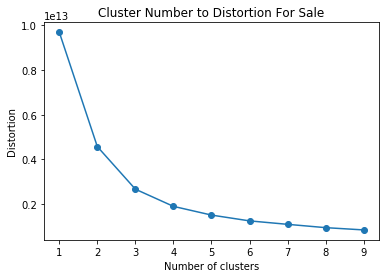

In [24]:
for_sale_res = run_k_mean(df_for_sale, 10, 'Cluster Number to Distortion For Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


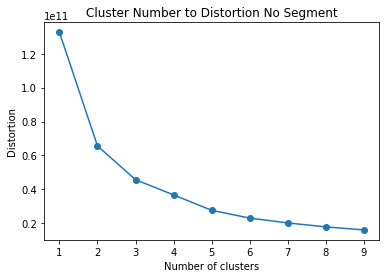

In [25]:
no_segment_res = run_k_mean(df_no_segment, 10, 'Cluster Number to Distortion No Segment')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


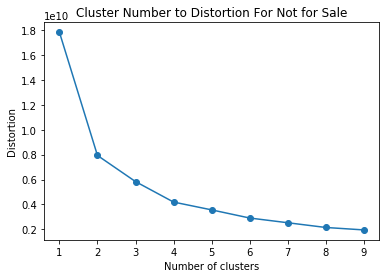

In [26]:
not_for_sale_res = run_k_mean(df_not_for_sale, 10, 'Cluster Number to Distortion For Not for Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


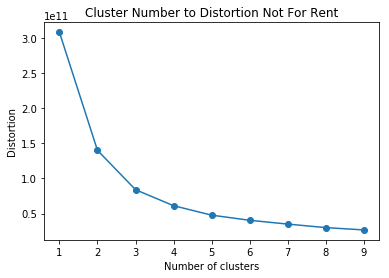

In [27]:
for_rent_res = run_k_mean(df_for_rent, 10, 'Cluster Number to Distortion Not For Rent')

In [28]:
normalized_for_sale_res_distortion = [i/max(for_sale_res[2]) for i in for_sale_res[2]]
print(normalized_for_sale_res_distortion)

[1.0, 0.4721692682602375, 0.2757952598422492, 0.1965558566904351, 0.15633056744150495, 0.1295490526360645, 0.11362902125167461, 0.09829874078299537, 0.08784887728973878]


In [29]:
normalized_no_segment_res_distortion = [i/max(no_segment_res[2]) for i in no_segment_res[2]]
print(normalized_no_segment_res_distortion)

[1.0, 0.4941378032069116, 0.34384272750392036, 0.27599683344749854, 0.20764402688248929, 0.17283500898540904, 0.15141141973841638, 0.1337282755396761, 0.1202232889945163]


In [32]:
normalized_not_for_sale_res_distortion = [i/max(not_for_sale_res[2]) for i in not_for_sale_res[2]]
print(normalized_not_for_sale_res_distortion)

[1.0, 0.4451382497405436, 0.32744251532604524, 0.23520532014875173, 0.20004272436799111, 0.16339049411785259, 0.14210681405874354, 0.12080067171707493, 0.10978783252533882]


In [33]:
normalized_for_rent_res_distortion = [i/max(for_rent_res[2]) for i in for_rent_res[2]]
print(normalized_for_rent_res_distortion)

[1.0, 0.45443983679525846, 0.2726078298867497, 0.19854610511996437, 0.15491665413097505, 0.13116220462443123, 0.11359234576026556, 0.09734314802437577, 0.08666792482030963]


## **Performance Summary of the Number of Clusters**

| Number of Clusters | For Sale Normalized Distortion | No Segment Normalized Distortion | Not For Sale Normalized Distortion | For Rent Normalized Distortion |
|------|------|------|------|------|
| 1  | 1 | 1 | 1 | 1 |
| 2  | 0.47 | 0.49 | 0.44  | 0.45 |
| 3  | 0.27 | 0.34 | 0.32 | 0.27 |
| 4  | 0.19 | 0.27 | 0.23 | 0.19 |
| 5  | 0.15 | 0.20 | 0.20 | 0.15 |
| 6  | 0.12 | 0.17 | 0.16 | 0.13 |
||||||
| **7**  | **0.11** | **0.15** | **0.14** | **0.11** |
||||||
| 8  | 0.09 | 0.13 | 0.12 | 0.09 |
| 9  | 0.08 | 0.12 | 0.10 | 0.08 |

## Conclusions:
7 Clusters is a good number